In [8]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tensorboard import SummaryWriter

import os

import inferno
from inferno.utils import to_numpy

from sine_data import train_dataset, valid_dataset
import insp

In [9]:
X_train, y_train = train_dataset()
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset()
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [93]:
writer = SummaryWriter()

In [94]:
class Latch(nn.Module):

    def __init__(self, size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.act = nn.Hardtanh(min_val=0, max_val=1)
        #self.consent_threshold = 0.75
        self.size = size
        
    def initial_q(self, batch_size):
        q = torch.zeros((batch_size, self.size))
        return Variable(q)

    def t(self, s):
        # all inputs in s must say 'store' or otherwise
        # there is no consent to store an value.
        #
        # we want that 
        # - most of the inputs agree
        # - the result is between 0 and 1 so we can use it as gate
        # - we want it to be differentiable and soft (well behaved gradients)
        x = s.sum(-1) / s.size(-1)
        return self.act(3/2 * x**4 + 1/8 * x**2)
        #return (self.act(s).mean(-1) >= self.consent_threshold).float()

    def forward(self, s, v, q):
        t = self.t(s).unsqueeze(-1)
        new_q = v * t + q * (1 - t)
        return new_q

In [145]:
class Block(nn.Module):
    def __init__(self, input_dim, output_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_units = output_dim

        self.latch_size = self.num_units
        self.latch = Latch(self.latch_size)

        self.units = nn.Linear(input_dim, output_dim)
        self.memory = nn.Linear(self.latch_size, self.num_units)
        self.set = nn.Parameter(torch.zeros(self.num_units) + 0.0)
        self.value = nn.Linear(self.num_units, self.latch_size)

        self.act = nn.Tanh()

    def forward(self, x):
        # x.shape = (b, t, u)
        t = x.size(1)
        acts = []
        qs = []
        q = self.latch.initial_q(x.size(0))
        for ti in range(t):
            u = self.units(x[:,ti])
            v = u + self.memory(q)
            q = self.latch(u, self.value(v), q)
            acts += [self.act(v)]
            qs += [q]
        return torch.stack(acts, dim=1), torch.stack(qs, dim=1)

In [146]:
class BlockLayer(nn.Module):
    def __init__(self, num_blocks, input_dim, output_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_blocks = num_blocks
        self.units_per_block = output_dim // num_blocks
        self.blocks = [Block(input_dim=input_dim,
                             output_dim=self.units_per_block)
                       for _ in range(num_blocks)]
        for i in range(len(self.blocks)):
            self.add_module('block_{}'.format(i), self.blocks[i])

    def forward(self, x):
        results = [block(x) for block in self.blocks]
        acts = [n[0] for n in results]
        qs = [n[1] for n in results]
        return torch.cat(acts, dim=-1), torch.cat(qs, dim=-1)

In [147]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [153]:
class BlockModel(nn.Module):
    def __init__(self, *args, baseline=False, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.baseline = baseline

        self.layer0_mem = BlockLayer(num_blocks=10,
                                     input_dim=1,
                                     output_dim=20)
        self.layer0_clf = nn.Linear(1 + 20, 20)
        
        self.layer1 = nn.Linear(20,100)
        self.softmax = nn.LogSoftmax()
        self.gru = nn.GRU(1, 20)
        self.iter = 0

    def forward(self, x):
        if not self.baseline:
            _, q0 = self.layer0_mem(x)
            writer.add_histogram('q0', q0.data.cpu().numpy(), self.iter)
            self.iter += 1
            merged0 = torch.cat([x, q0], dim=-1)

            l0_clf = self.layer0_clf(time_flatten(merged0))
        else:
            l0_clf = time_flatten(self.gru(x)[0])
        
        l1 = self.layer1(l0_clf)
        
        return time_unflatten(self.softmax(l1), x.size())

In [154]:
def one_hot(shape, hot_idx):
    t = torch.zeros(shape)
    t[:, hot_idx] = 1
    return Variable(t)
    
class Trainer(inferno.NeuralNet):
    
    def __init__(self, 
                 criterion=nn.NLLLoss,
                 *args, 
                 **kwargs):
        self.iter = 0
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        #pred = y_pred[:,-1]
        #true = one_hot(pred.size(), y_true)
        pred = y_pred[:,-1]
        true = y_true
        return super().get_loss(pred, true, X=X, train=train)
    
    def train_step(self, *args, **kwargs):
        for name, param in self.module_.named_parameters():
            writer.add_histogram(name, param.data.cpu().numpy(), self.iter)
        self.iter += 1
        return super().train_step(*args, **kwargs)

In [155]:
from sine_data import *

X_train, y_train = train_dataset()
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset()
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

In [156]:
ef = Trainer(module=BlockModel,
             optim=torch.optim.RMSprop,
             lr=0.005,
             max_epochs=60,
             module__baseline=False,
            )

In [ ]:
%pdb on
ef.fit(X_train, y_train)

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.5669        3.8435  2.5263
      2        3.3320        4.7242  2.4115
      3        2.0086        6.0453  2.4170
      4        1.7577        6.6964  2.5881
      5        1.1934       32.1075  2.4617
      6        1.0818        9.5162  2.8549
      7        1.2729       13.1554  2.6920
      8        0.9248      111.7252  3.5917
      9        0.9607       17.3998  3.0806
     10        1.1326       12.3921  2.8112
     11        1.0840       15.9391  2.8545
     12        1.0455       14.0424  2.6067
     13        0.8153       16.4492  2.6786
     14        0.7677       17.4602  2.9129
     15        0.7375       19.1178  2.6604
     16        0.7121       20.8076  2.6140
     17        0.6887       23.7484  2.5993
     18        0.6666       26.7244  2.5454
     19        0.6461       31.8149  2.4298
     20        0.6333       33.5576

Supervised
0 Acc (sup): 0.0
0 MAE(pred,target) 0.113740913875
Supervised
1 Acc (sup): 1.0
1 MAE(pred,target) 0.0
Supervised
2 Acc (sup): 0.0
2 MAE(pred,target) 1.18885385195
Supervised
3 Acc (sup): 0.0
3 MAE(pred,target) 1.59944068591
Supervised
4 Acc (sup): 1.0
4 MAE(pred,target) 0.0


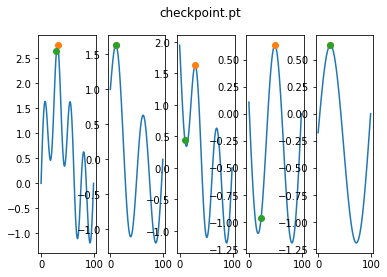

In [142]:
import insp
import imp; imp.reload(insp)
%matplotlib inline
insp.plot(ef.module_, dataset='train')